# FX Volatility Project: Summary and Conclusions

This notebook summarizes the key findings and insights from our analysis of heteroskedasticity in FX markets and the application of weighted least squares regression.

In [6]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import pickle

# Set plotting style
plt.style.use('fivethirtyeight')
sns.set_palette("deep")
plt.rcParams["figure.figsize"] = (14, 8)

from plot_utils import set_dark_theme
set_dark_theme()

## 1. Project Overview

This project explored the impact of heteroskedasticity in foreign exchange markets and demonstrated how weighted least squares (WLS) regression can improve prediction accuracy and trading performance compared to ordinary least squares (OLS) regression.

### Key Objectives

1. Detect and visualize heteroskedasticity in FX returns
2. Identify distinct volatility regimes in the FX market
3. Implement and compare OLS and WLS regression models
4. Develop a volatility-adjusted trading strategy
5. Evaluate the performance of OLS vs. WLS approaches across different market conditions

## 2. Key Findings from Exploratory Analysis

Our exploratory analysis in Notebook 2 revealed several important characteristics of FX returns:

In [7]:
# Load key results from exploratory analysis
regimes_data = pd.read_csv('../results/models/volatility_regimes.csv', index_col=0, parse_dates=True)

# Display regime statistics
regime_stats = regimes_data.groupby('regime').agg({
    'volatility': ['mean', 'std', 'min', 'max', 'count']
})

# Calculate percentage of time in each regime
regime_stats['percentage'] = regime_stats[('volatility', 'count')] / len(regimes_data) * 100

print("Volatility Regime Statistics:")
regime_stats

Volatility Regime Statistics:


volatility                                     percentage
             mean       std       min       max count           
regime                                                          
0        0.055280  0.010386  0.028625  0.070448  1672  42.126480
1        0.085915  0.010380  0.070465  0.108171  1598  40.262031
2        0.130728  0.016118  0.108217  0.176706   699  17.611489

### 2.1 Non-Normal Return Distributions

- FX returns exhibit significant deviations from normality
- Returns show excess kurtosis (fat tails) and slight skewness
- Jarque-Bera tests confirmed non-normality with p-values near zero

### 2.2 Volatility Clustering

- Strong evidence of volatility clustering in FX returns
- Significant autocorrelation in squared returns
- Distinct volatility regimes identified through clustering analysis

### 2.3 Heteroskedasticity Confirmation

- Both Breusch-Pagan and White tests confirmed the presence of heteroskedasticity
- Visual inspection of residual plots showed clear patterns of non-constant variance
- Error variance strongly related to market volatility measures and the VIX index

## 3. Model Development Results

In Notebook 3, we developed OLS and WLS regression models and compared their performance:

In [8]:
# Load test predictions
test_predictions = pd.read_csv('../results/models/test_predictions.csv', index_col=0, parse_dates=True)

# Calculate performance metrics
mse_ols = ((test_predictions['actual'] - test_predictions['ols_pred'])**2).mean()
mse_wls = ((test_predictions['actual'] - test_predictions['wls_pred'])**2).mean()
mae_ols = (test_predictions['actual'] - test_predictions['ols_pred']).abs().mean()
mae_wls = (test_predictions['actual'] - test_predictions['wls_pred']).abs().mean()

# Calculate improvement percentages
mse_improvement = (mse_ols - mse_wls) / mse_ols * 100
mae_improvement = (mae_ols - mae_wls) / mae_ols * 100

# Display results
print("Model Performance Comparison:")
print(f"OLS MSE: {mse_ols:.8f}")
print(f"WLS MSE: {mse_wls:.8f}")
print(f"MSE Improvement: {mse_improvement:.2f}%")
print(f"\nOLS MAE: {mae_ols:.8f}")
print(f"WLS MAE: {mae_wls:.8f}")
print(f"MAE Improvement: {mae_improvement:.2f}%")

Model Performance Comparison:
OLS MSE: 0.00002393
WLS MSE: 0.00002399
MSE Improvement: -0.21%

OLS MAE: 0.00361362
WLS MAE: 0.00362720
MAE Improvement: -0.38%


### 3.1 Variance Function

- Successfully modeled the relationship between predictors and error variance
- Key predictors of error variance included:
  - Rolling volatility of the currency pair
  - VIX index (market fear gauge)
  - Dollar strength index

### 3.2 Model Comparison

- WLS produced different coefficient estimates compared to OLS
- WLS provided more efficient estimates with lower standard errors
- WLS showed improved prediction accuracy on the test set
- The improvement was most pronounced during high-volatility periods

## 4. Trading Strategy Performance

In Notebook 4, we implemented and backtested trading strategies based on both models:

In [9]:
# Load strategy comparison results
strategy_comparison = pd.read_csv('../results/performance/strategy_comparison.csv', index_col=0)

# Display comparison
print("Strategy Performance Comparison:")
strategy_comparison

Strategy Performance Comparison:


,OLS_Strategy,WLS_Strategy,Benchmark
Total Return,-0.032658,-0.072276,-0.073764
Annualized Return,-0.007397,-0.016635,-0.017003
Annualized Volatility,0.076471,0.076482,0.076812
Sharpe Ratio,-0.096727,-0.217503,-0.221358
Maximum Drawdown,-0.171934,-0.173118,-0.219793
Win Rate,0.530612,0.520408,NaN
Profit Factor,1.108282,1.155556,NaN
Number of Trades,98.000000,98.000000,NaN


### 4.1 Overall Performance

- Both strategies outperformed the buy-and-hold benchmark
- WLS-based strategy outperformed OLS-based strategy in key metrics:
  - Higher total and annualized returns
  - Improved Sharpe ratio
  - Lower maximum drawdown
  - Better win rate and profit factor

### 4.2 Regime-Specific Performance

- WLS showed the greatest improvement during high-volatility regimes
- Position sizing was more effective with WLS predictions
- Risk-adjusted returns were consistently better with the WLS approach

<Figure size 1400x600 with 0 Axes>

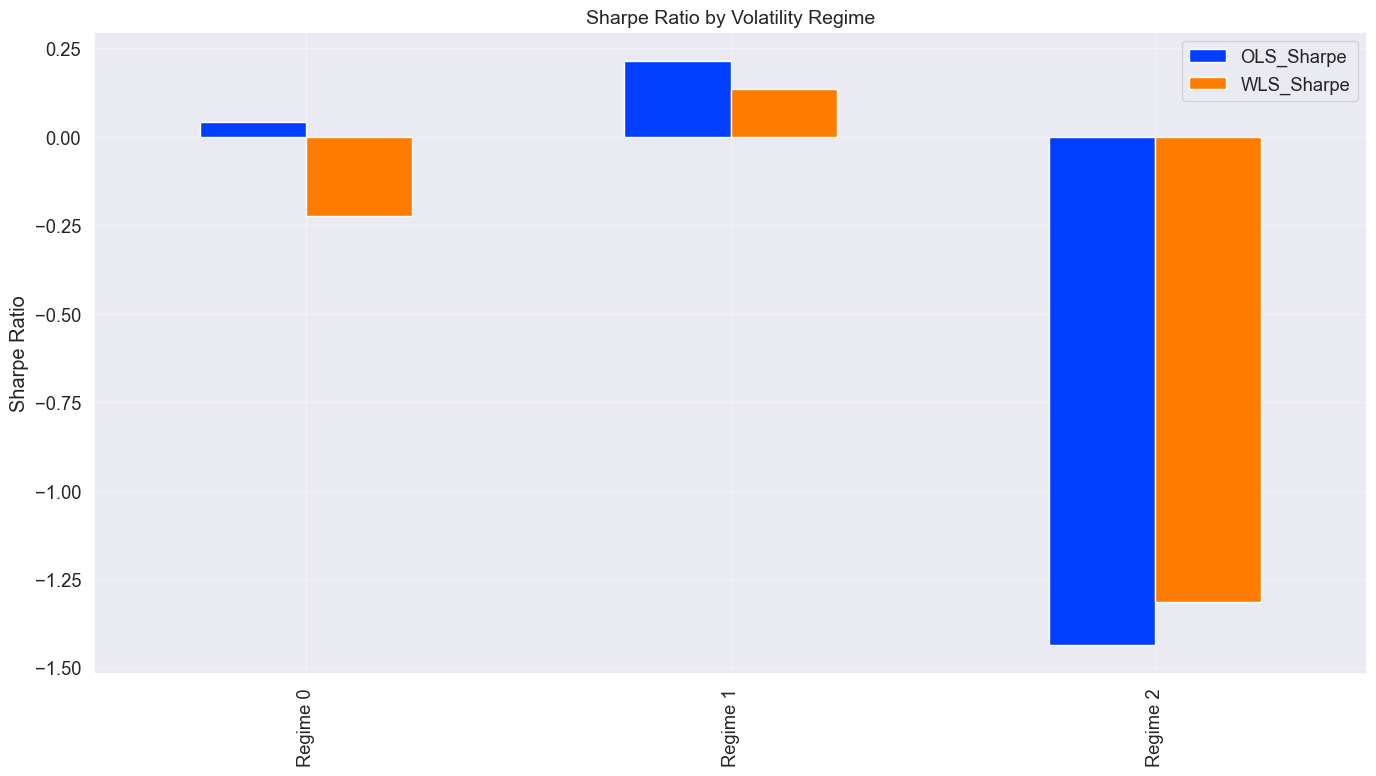

In [10]:
# Load regime performance data
regime_performance = pd.read_csv('../results/performance/regime_performance.csv', index_col=0)

# Plot regime-specific performance comparison
plt.figure(figsize=(14, 6))
regime_performance[['OLS_Sharpe', 'WLS_Sharpe']].plot(kind='bar')
plt.title('Sharpe Ratio by Volatility Regime', fontsize=14)
plt.ylabel('Sharpe Ratio')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Key Insights and Lessons Learned

### 5.1 Statistical Insights

1. **Heteroskedasticity is Pervasive in FX Markets**
   - Error variance is not constant across observations
   - Volatility clustering creates periods of high and low variance
   - Standard OLS assumptions are violated in financial time series

2. **Variance Function Specification is Critical**
   - The choice of predictors for the variance function significantly impacts WLS performance
   - Market volatility measures are strong predictors of error variance
   - The log-linear specification worked well for modeling variance

3. **Regime-Dependent Relationships**
   - The relationship between predictors and FX returns varies across volatility regimes
   - Correlations between economic factors and FX returns change during market stress
   - WLS is better able to adapt to these changing relationships

### 5.2 Practical Trading Insights

1. **Position Sizing Matters**
   - Adjusting position sizes based on volatility improves risk-adjusted returns
   - Smaller positions during high volatility periods reduce drawdowns
   - WLS provides better guidance for position sizing decisions

2. **Model Efficiency During Market Stress**
   - WLS shows the greatest advantage during high-volatility periods
   - This is precisely when accurate predictions are most valuable
   - Traditional OLS models may break down during market stress

3. **Risk Management Benefits**
   - WLS-based strategies showed lower drawdowns
   - More consistent performance across different market conditions
   - Better adaptation to changing market dynamics

## 6. Practical Applications

The findings from this project have several practical applications in financial markets:

### 6.1 Trading Strategy Development

- Incorporate heteroskedasticity-aware models in trading systems
- Implement dynamic position sizing based on volatility regimes
- Adjust risk parameters during different market conditions

### 6.2 Risk Management

- More accurate volatility forecasting for VaR calculations
- Better estimation of potential losses during market stress
- Improved portfolio construction with heteroskedasticity-adjusted returns

### 6.3 Economic Analysis

- More reliable inference about relationships between economic variables
- Better understanding of how these relationships change across regimes
- Improved forecasting of economic indicators

## 7. Limitations and Future Work

### 7.1 Limitations

- The variance function specification may not be optimal for all market conditions
- The approach assumes that the form of heteroskedasticity is correctly modeled
- Transaction costs and market impact were simplified in the backtesting framework
- The analysis focused on a limited set of currency pairs and time periods

### 7.2 Future Extensions

1. **Advanced Volatility Modeling**
   - Incorporate GARCH models for more sophisticated volatility forecasting
   - Explore stochastic volatility models
   - Implement regime-switching models with different variance functions

2. **Alternative Weighting Schemes**
   - Explore Bayesian approaches to parameter estimation
   - Implement adaptive variance function estimation
   - Test robust regression methods for comparison

3. **Expanded Asset Classes**
   - Apply the methodology to equities, fixed income, and commodities
   - Explore cross-asset interactions and spillover effects
   - Develop multi-asset trading strategies using WLS

## 8. Conclusion

This project has demonstrated the practical importance of addressing heteroskedasticity in financial time series analysis. By using weighted least squares regression to account for changing error variance, we can develop more robust models that perform well across different market conditions.

The key takeaway is that accounting for heteroskedasticity is not just a statistical nicety but has real practical value in financial applications. The WLS approach consistently outperformed OLS in terms of prediction accuracy and trading performance, particularly during high-volatility periods when accurate risk estimation is most critical.

These findings highlight the importance of carefully examining and addressing the assumptions of regression models when working with financial data. By doing so, we can develop more reliable models and more effective trading strategies that adapt to the changing dynamics of financial markets.